In [1]:
import geostatspy.GSLIB as GSLIB                          # Utilidades GSLIB y funciones envueltas
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import os                                                 # Para configurar el directorio de trabajo
import numpy as np                                        # Biblioteca de funciones matemáticas
import pandas as pd                                       # Biblioteca para manipulación de marcos de datos
import matplotlib.pyplot as plt                           # Biblioteca para salida gráfica
import scipy.stats                                        # Biblioteca de resumenes estadísticos y matemáticos
import random as rand
from sklearn.metrics import r2_score
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.optimizers import RMSprop 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
import pygeostat as gs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from RBFN import *
plt.rcParams.update(plt.rcParamsDefault)

os.chdir("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER") # ruta de ejecutables de GSLIB

In [2]:
nx = 100; ny = 50; cell_size=10                             # grid number of cells and cell size
xmin = 0; ymin =0;                                          # grid origin
xmax = 1000; ymax = 500    # calculate the extent of model
seed = 172763650
vmin = 0; vmax = 1; cmap = plt.cm.jet                     # color min and max and using the plasma color map
va_mean = 2; va_stdev = 0.55; va_cmin = 0; va_cmax = 4
var = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=250,hmin1=250)
V = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed,var,"u")
V = GSLIB.affine(V,va_mean,va_stdev)
df_zko = pd.DataFrame(V)
df11 = df_zko.stack().reset_index().rename(columns={"level_0": "Elevation[Z]", "level_1": "Este[X]", 0:"V"})
x = df11["Elevation[Z]"].iloc[::-1].reset_index()
df11["Elevation[Z]"] = x["Elevation[Z]"]
##############################################################################################################
grid_x = np.linspace(0,500, num=50, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_y = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.
gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 
yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)
x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg
d = {'X': x_g, 'Y': y_g} #Columnas con coordenadas X e Y.
df = pd.DataFrame(data=d) #Creación del dataframe 
h = df["Y"].iloc[::-1].reset_index()
df["Y"] = h["Y"]
df["V"] = df11["V"] #Traspaso de la columna VA al nuevo DataFrame.
df.to_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Hybrid_model_test_2023/data_test_2.csv")
#valores_x = [50, 350,650,8950]
valores_x = [50,250,350,450,550,650,750,950]
df_filtrado = df[df['X'].isin(valores_x)].copy()

for x in [950]:
    df_filtrado = df_filtrado.loc[~((df_filtrado['X'] == x) & ((df_filtrado['Y'] <= 300)))]
    
for x in [50]:
    df_filtrado = df_filtrado.loc[~((df_filtrado['X'] == x) & ((df_filtrado['Y'] <= 300)))]

df_filtrado.to_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Hybrid_model_test_2023/sample_dh_test2.csv")

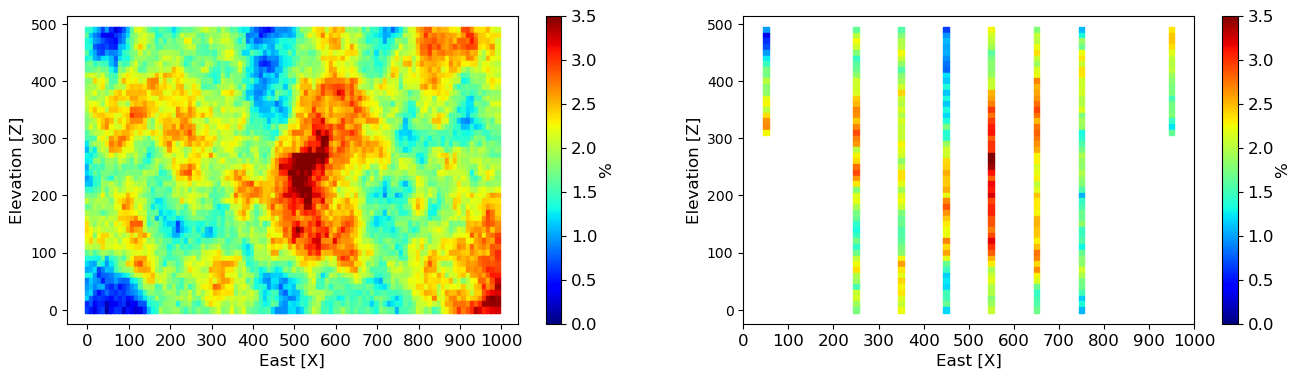

In [3]:
marker_size=16
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["V"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df_filtrado["X"], df_filtrado["Y"], marker_size,df_filtrado["V"], cmap = cmap, marker="s")
#plt.title("Drillholes spacing 150 m", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Figuras paper 1/figure_2.png", dpi=300)
plt.show()

In [4]:
df["V"].min()

0.09669299955415167

In [5]:
corte = 2.2

df["GEO"] = 0  # Inicializar con 0
df_filtrado['GEO'] = 0  # Inicializar con 0

# Para df
df["GEO"] = (df["V"] > corte).astype(int)

# Para df_filtrado
df_filtrado['GEO'] = (df_filtrado['V'] > corte).astype(int)

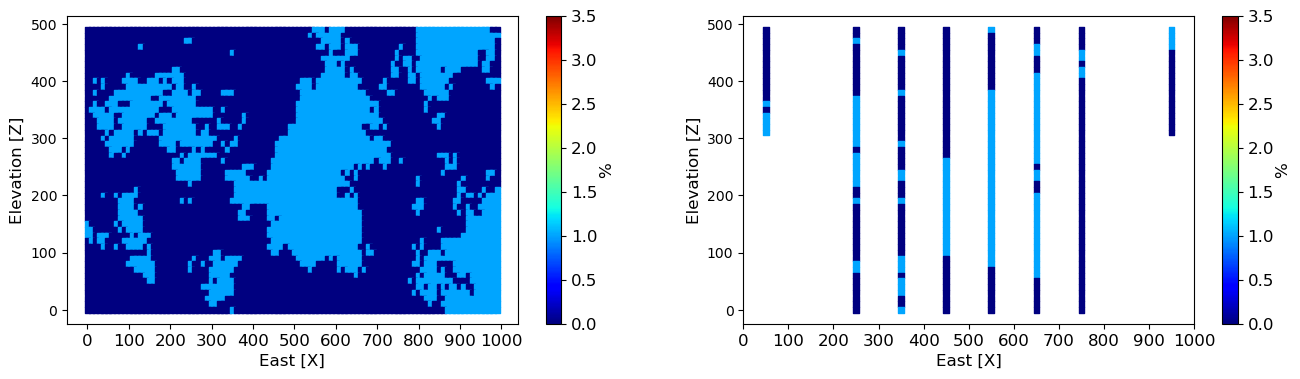

In [6]:
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["GEO"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df_filtrado["X"], df_filtrado["Y"], marker_size,df_filtrado["GEO"], cmap = cmap, marker="s")
#plt.title("Drillholes spacing 150 m", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Figuras paper 1/figure_2.png", dpi=300)
plt.show()

[]

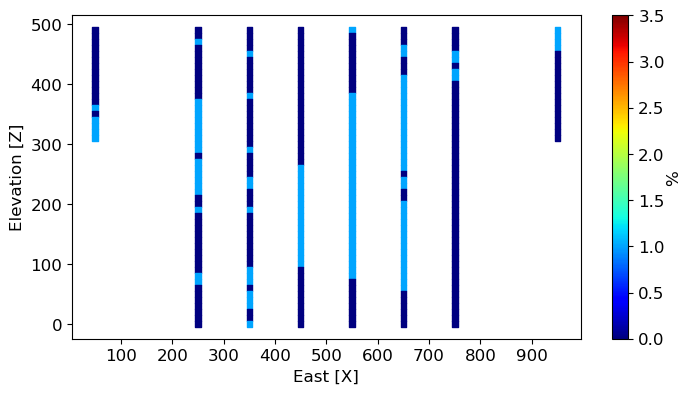

In [7]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df_filtrado["X"], df_filtrado["Y"], marker_size,df_filtrado["GEO"], cmap = cmap, marker="s")
#plt.title("Drillholes spacing 150 m", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/sample_desagrupada.png", dpi=300)
plt.plot()

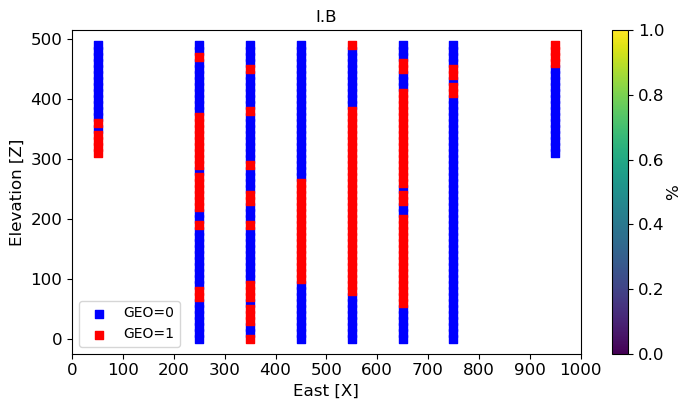

In [80]:

X1 = df_filtrado['X']
Y1 = df_filtrado['Y']
V1 = df_filtrado['GEO']

marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(X1[V1 == 0], Y1[V1 == 0], color='blue', marker='s', label='GEO=0')
plt.scatter(X1[V1 == 1], Y1[V1 == 1], color='red', marker='s', label='GEO=1')
plt.legend()
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.title("I.B")
cbar = plt.colorbar()


cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/sample_geo.png", dpi=300)
plt.show()


**B.	Muestreo irregular donde se conoce la ley mineral y un control geológico**

In [9]:
df_filtrado.describe().T

,count,mean,std,min,25%,50%,75%,max
X,338.0,500.000000,220.903191,50.000000,350.000000,500.000000,650.000000,950.000000
Y,338.0,262.426036,145.881244,0.000000,140.000000,280.000000,390.000000,490.000000
V,338.0,2.043045,0.544606,0.328641,1.697173,2.069206,2.367995,3.546454
GEO,338.0,0.381657,0.486513,0.000000,0.000000,0.000000,1.000000,1.000000


# Modelo MLP:

In [10]:
X = df_filtrado.drop(["V"],axis=1) 
y = df_filtrado["V"]
X.head()

,X,Y,GEO
5,50.0,490.0,0
25,250.0,490.0,0
35,350.0,490.0,0
45,450.0,490.0,0
55,550.0,490.0,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,random_state=17276)

In [12]:
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
X_train.rename(columns={0:"X", 1:"Y", 2: "GEO"}, inplace=True)
X_test.rename(columns={0:"X", 1:"Y", 2: "GEO"}, inplace=True)

In [13]:
network = models.Sequential()
network.add(layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(1)) 
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12801 (50.00 KB)
Trainable params: 12801 (50.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
network.compile(
   loss = 'mean_squared_error', 
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)

In [15]:
history = network.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/1000
10/10 [==============================] - 3s 63ms/step - loss: 1.4615 - val_loss: 0.8265
Epoch 2/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.3578 - val_loss: 0.2624
Epoch 3/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1610 - val_loss: 0.2175
Epoch 4/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1184 - val_loss: 0.1906
Epoch 5/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1121 - val_loss: 0.1776
Epoch 6/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1028 - val_loss: 0.1523
Epoch 7/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1003 - val_loss: 0.1646
Epoch 8/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0981 - val_loss: 0.1519
Epoch 9/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0976 - val_loss: 0.1513
Epoch 10/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0943 - val_lo

10/10 [==============================] - 0s 12ms/step - loss: 0.0430 - val_loss: 0.0951
Epoch 82/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0348 - val_loss: 0.0780
Epoch 83/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0334 - val_loss: 0.0734
Epoch 84/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0339 - val_loss: 0.0780
Epoch 85/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0326 - val_loss: 0.0707
Epoch 86/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0331 - val_loss: 0.1114
Epoch 87/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0521 - val_loss: 0.0851
Epoch 88/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0491 - val_loss: 0.0744
Epoch 89/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0383 - val_loss: 0.0832
Epoch 90/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0387 - val_loss: 0

Epoch 161/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0274 - val_loss: 0.0626
Epoch 162/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0277 - val_loss: 0.0460
Epoch 163/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0256 - val_loss: 0.0477
Epoch 164/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0241 - val_loss: 0.0418
Epoch 165/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0278 - val_loss: 0.0778
Epoch 166/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0266 - val_loss: 0.0635
Epoch 167/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0382 - val_loss: 0.0719
Epoch 168/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0371 - val_loss: 0.0682
Epoch 169/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0350 - val_loss: 0.0906
Epoch 170/1000
10/10 [==============================] - 0s 16ms/step - lo

10/10 [==============================] - 0s 10ms/step - loss: 0.0253 - val_loss: 0.0647
Epoch 241/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0278 - val_loss: 0.0556
Epoch 242/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0318 - val_loss: 0.0464
Epoch 243/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0326 - val_loss: 0.0829
Epoch 244/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0278 - val_loss: 0.0699
Epoch 245/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0249 - val_loss: 0.0758
Epoch 246/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0214 - val_loss: 0.0478
Epoch 247/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0244 - val_loss: 0.0544
Epoch 248/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0268 - val_loss: 0.0810
Epoch 249/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0295 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0224 - val_loss: 0.0876
Epoch 320/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0222 - val_loss: 0.0451
Epoch 321/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0216 - val_loss: 0.0553
Epoch 322/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0211 - val_loss: 0.0515
Epoch 323/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0214 - val_loss: 0.0624
Epoch 324/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0202 - val_loss: 0.0498
Epoch 325/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0190 - val_loss: 0.0400
Epoch 326/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0227 - val_loss: 0.0832
Epoch 327/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0220 - val_loss: 0.0509
Epoch 328/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0200 - va

10/10 [==============================] - 0s 14ms/step - loss: 0.0181 - val_loss: 0.0443
Epoch 399/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0170 - val_loss: 0.0503
Epoch 400/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0176 - val_loss: 0.0482
Epoch 401/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0194 - val_loss: 0.0540
Epoch 402/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0174 - val_loss: 0.0484
Epoch 403/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0224 - val_loss: 0.0396
Epoch 404/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0204 - val_loss: 0.0739
Epoch 405/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0181 - val_loss: 0.0522
Epoch 406/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0185 - val_loss: 0.0417
Epoch 407/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0206 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0173 - val_loss: 0.0547
Epoch 478/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0183 - val_loss: 0.0451
Epoch 479/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0499
Epoch 480/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0211 - val_loss: 0.0713
Epoch 481/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0180 - val_loss: 0.0394
Epoch 482/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0492
Epoch 483/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0155 - val_loss: 0.0404
Epoch 484/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0174 - val_loss: 0.0459
Epoch 485/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0181 - val_loss: 0.0465
Epoch 486/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0160 - va

10/10 [==============================] - 0s 14ms/step - loss: 0.0185 - val_loss: 0.0425
Epoch 557/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0206 - val_loss: 0.0442
Epoch 558/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0200 - val_loss: 0.0562
Epoch 559/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0178 - val_loss: 0.0463
Epoch 560/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0181 - val_loss: 0.0575
Epoch 561/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0540
Epoch 562/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0184 - val_loss: 0.0407
Epoch 563/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0171 - val_loss: 0.0711
Epoch 564/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0185 - val_loss: 0.0445
Epoch 565/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0167 - va

10/10 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.0549
Epoch 636/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0488
Epoch 637/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0154 - val_loss: 0.0525
Epoch 638/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0166 - val_loss: 0.0504
Epoch 639/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0161 - val_loss: 0.0433
Epoch 640/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0157 - val_loss: 0.0476
Epoch 641/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0217 - val_loss: 0.0781
Epoch 642/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0232 - val_loss: 0.0507
Epoch 643/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0207 - val_loss: 0.0566
Epoch 644/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0188 - va

10/10 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0378
Epoch 715/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0148 - val_loss: 0.0617
Epoch 716/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0154 - val_loss: 0.0331
Epoch 717/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.0500
Epoch 718/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0149 - val_loss: 0.0456
Epoch 719/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0139 - val_loss: 0.0303
Epoch 720/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0155 - val_loss: 0.0437
Epoch 721/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0160 - val_loss: 0.0554
Epoch 722/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0166 - val_loss: 0.0411
Epoch 723/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0164 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0183 - val_loss: 0.0722
Epoch 794/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0201 - val_loss: 0.0476
Epoch 795/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0159 - val_loss: 0.0677
Epoch 796/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0391
Epoch 797/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0182 - val_loss: 0.0601
Epoch 798/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0513
Epoch 799/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0606
Epoch 800/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0189 - val_loss: 0.0431
Epoch 801/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0158 - val_loss: 0.0493
Epoch 802/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0155 - va

10/10 [==============================] - 0s 14ms/step - loss: 0.0190 - val_loss: 0.1020
Epoch 873/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0253 - val_loss: 0.1012
Epoch 874/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0219 - val_loss: 0.1068
Epoch 875/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0218 - val_loss: 0.1004
Epoch 876/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0188 - val_loss: 0.0803
Epoch 877/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0189 - val_loss: 0.0849
Epoch 878/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0196 - val_loss: 0.0630
Epoch 879/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0177 - val_loss: 0.0644
Epoch 880/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0162 - val_loss: 0.0751
Epoch 881/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0150 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0143 - val_loss: 0.0613
Epoch 952/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0147 - val_loss: 0.0694
Epoch 953/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0139 - val_loss: 0.0773
Epoch 954/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0133 - val_loss: 0.0499
Epoch 955/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0151 - val_loss: 0.0553
Epoch 956/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0149 - val_loss: 0.0513
Epoch 957/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0156 - val_loss: 0.0492
Epoch 958/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0529
Epoch 959/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0473
Epoch 960/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0127 - va

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = network.predict(X_train)
y_test_pred = network.predict(X_test)

# Métricas en el conjunto de entrenamiento
r_train = np.corrcoef(y_train, y_train_pred.squeeze())[0, 1]
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Métricas en el conjunto de prueba
r_test = np.corrcoef(y_test, y_test_pred.squeeze())[0, 1]
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Imprimir las métricas
print("Métricas en el conjunto de entrenamiento:")
print("R:", r_train)
print("R2:", r2_train)
print("MSE:", mse_train)
print("RMSE:", rmse_train)
print("MAE:", mae_train)
print("")

print("Métricas en el conjunto de prueba:")
print("R:", r_test)
print("R2:", r2_test)
print("MSE:", mse_test)
print("RMSE:", rmse_test)
print("MAE:", mae_test)

2/2 [==============================] - 0s 15ms/step
Métricas en el conjunto de entrenamiento:
R: 0.9794510419046565
R2: 0.9557988546216836
MSE: 0.01230930857405246
RMSE: 0.11094732341995664
MAE: 0.07939351802321491

Métricas en el conjunto de prueba:
R: 0.9498004181628119
R2: 0.8785553709363512
MSE: 0.0541492312505652
RMSE: 0.23269987376568385
MAE: 0.18797557984290722


In [17]:
grid_x = np.linspace(0,500, num=50, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_y = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.

#En este caso la matriz es de 100 x 100 celdas.

gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 

yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)

x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg

d = {'Este[X]': x_g, 'Norte[Y]': y_g} #Columnas con coordenadas X e Y.
df2 = pd.DataFrame(data=d) #Creación del dataframe 

h = df2["Norte[Y]"].iloc[::-1].reset_index()

df2["Norte[Y]"] = h["Norte[Y]"]

df2 = pd.DataFrame(StandardScaler().fit_transform(df2))

df2.rename(columns={0:"X", 1:"Y"}, inplace=True)
df3 = df2.copy()

#df5 = df_filtrado.reset_index()

df2["GEO"] = df["GEO"]

df2.head()

,X,Y,GEO
0,-1.714816,1.697749,0
1,-1.680173,1.697749,0
2,-1.645531,1.697749,0
3,-1.610888,1.697749,0
4,-1.576245,1.697749,0


In [18]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5000.0,8.526513e-18,1.000100,-1.714816,-0.857408,0.0,0.857408,1.714816
Y,5000.0,-9.094947e-17,1.000100,-1.697749,-0.866199,0.0,0.866199,1.697749
GEO,5000.0,3.516000e-01,0.477518,0.000000,0.000000,0.0,1.000000,1.000000


In [19]:
y_pred3 = network.predict(df2) #uso del modelo para un conjunto nuevo de datos de entrada (bloques zona óxido)
df2["VA_RNA"] = y_pred3
df["VA_RNA"] = df2["VA_RNA"]
df.head()

157/157 [==============================] - 1s 4ms/step


,X,Y,V,GEO,VA_RNA
0,0.0,490.0,1.425655,0,1.439603
1,10.0,490.0,1.398962,0,1.422443
2,20.0,490.0,1.188708,0,1.405215
3,30.0,490.0,0.992036,0,1.392186
4,40.0,490.0,0.680945,0,1.381803


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5000.0,495.00000,288.689571,0.000000,247.500000,495.000000,742.500000,990.000000
Y,5000.0,245.00000,144.323130,0.000000,120.000000,245.000000,370.000000,490.000000
V,5000.0,2.00000,0.550055,0.096693,1.642968,2.000339,2.364052,3.931615
GEO,5000.0,0.35160,0.477518,0.000000,0.000000,0.000000,1.000000,1.000000
VA_RNA,5000.0,1.98473,0.430653,0.651779,1.706716,1.955750,2.245511,3.376422


In [21]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Supongamos que tienes dos arrays con valores reales (y_true) y predicciones (y_pred)
y_true = df["V"] 
y_pred = df["VA_RNA"] 

# Calcular las métricas
r = np.corrcoef(y_true, y_pred)[0, 1]
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# Imprimir los resultados
print(f"Coeficiente de correlación (R): {r:.4f}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

Coeficiente de correlación (R): 0.6518
Coeficiente de determinación (R²): 0.4069
RMSE: 0.4236
MSE: 0.1794
MAE: 0.3191


[]

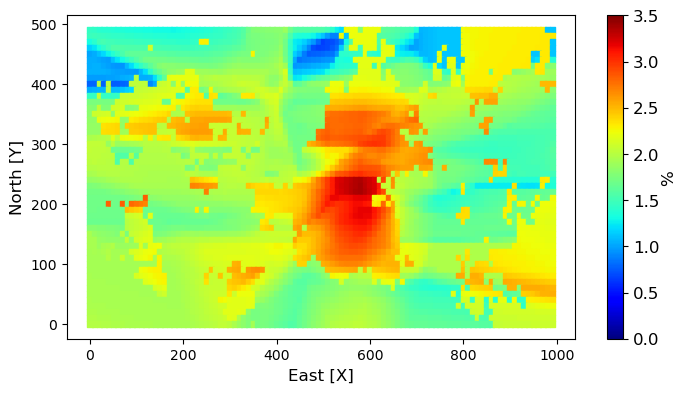

In [22]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
marker_size=15
plt.scatter(df["X"], df["Y"], marker_size, df2["VA_RNA"], cmap = cmap, marker="s")
#plt.title("Hybrid Model (Kriging and Neural Network)")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/sample_regular_mlp_100.png", dpi=300)
plt.plot()

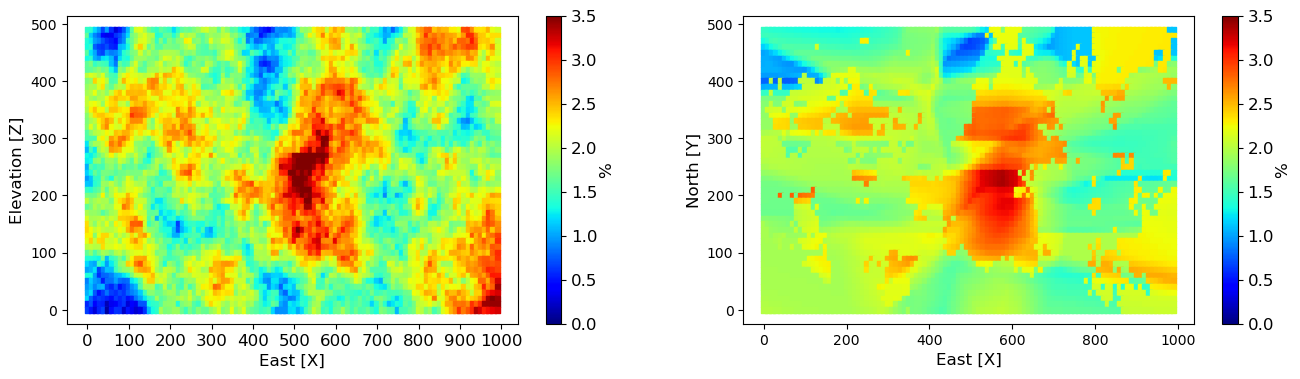

In [23]:
marker_size=16
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["V"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df["X"], df["Y"], marker_size, df2["VA_RNA"], cmap = cmap, marker="s")
#plt.title("Hybrid Model (Kriging and Neural Network)")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Figuras paper 1/figure_2.png", dpi=300)
plt.show()

# MODELO OK:

In [24]:
lag000, vario000, npp000 = GSLIB.gamv_2d(df_filtrado,'X','Y','V',20,25,0,12.5,25)
lag090, vario090, npp090 = GSLIB.gamv_2d(df_filtrado,'X','Y','V',20,25,90,12.5,25)


In [25]:
df_filtrado["V"].var()

0.2965961361135752

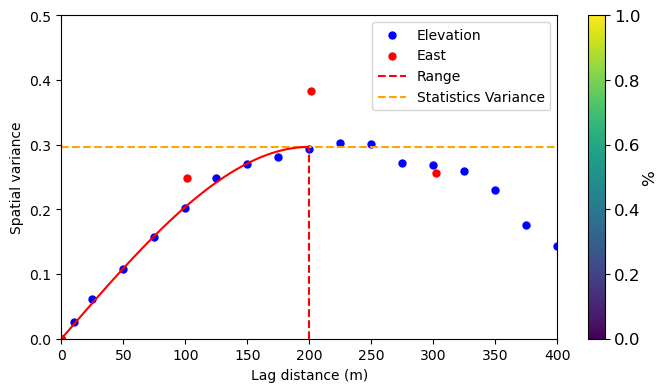

In [46]:
fig = plt.figure(figsize=(8,4.2))
plt.scatter(lag000,vario000,s=25,marker='o',color = 'blue',label = 'Elevation')
plt.scatter(lag090,vario090,s=25,marker='o',color = 'red',label = 'East')

alcance = 200
meseta = df_filtrado["V"].var()

plt.plot([alcance,alcance],[0,meseta],color = 'red', label="Range", linestyle='dashed')

plt.plot([0,alcance*2],[meseta,meseta],color = 'orange',label = 'Statistics Variance', linestyle='dashed')



x = np.arange(0,alcance,1)
y = ((1.5*(x/alcance)) - (0.5*(x/alcance)**3))*meseta
plt.plot(x,y, color = 'red')
plt.xlabel('Lag distance (m)')
plt.ylabel('Spatial variance')
plt.ylim(0,0.5)
plt.xlim(0,400)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::], labels[::])
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/variograma_modelo.png", dpi=300)

plt.show()

In [27]:
vario_kri = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=meseta,azi1=0,hmaj1=200,hmin1=200) #ajuste con un unico modelo esférico 

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


In [28]:
nx = 100; ny=50; xsiz=10; ysiz=10; xmn=0; ymn= 0; ndmax=20; ndmin=1;radius=200; 

ktype=1; skmean=0; nxdis=1; nydis=1; tmin=-9999; tmax=9999

kmap, vmap = geostats.kb2d(df_filtrado, "X", "Y", "V", tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, nxdis, nydis, ndmin, ndmax, radius, ktype, skmean, vario_kri)

  Estimated   5000 blocks 
      average   1.9716064651814784  variance  0.18067696724712734


In [29]:
xmin = 0; ymin =0;                                          # grid origin

xmax = 1000; ymax = 500    # calculate the extent of model

In [30]:
df_kmap = pd.DataFrame(kmap) #se pasan los valores estimados al dataframe de la simulación 
df_vmap = pd.DataFrame(vmap) #se pasan los valores estimados al dataframe de la simulación 

df_vmap = df_vmap.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Var"})
df_kmap = df_kmap.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Ore grade"})

df["Var"] = df_vmap["Var"]
df["V_OK"]= df_kmap["Ore grade"]
df.head()

,X,Y,V,GEO,VA_RNA,Var,V_OK
0,0.0,490.0,1.425655,0,1.439603,0.187132,1.062005
1,10.0,490.0,1.398962,0,1.422443,0.152383,0.996280
2,20.0,490.0,1.188708,0,1.405215,0.116073,0.929009
3,30.0,490.0,0.992036,0,1.392186,0.078479,0.867346
4,40.0,490.0,0.680945,0,1.381803,0.039985,0.839161


In [31]:
df["V_OK"].describe().T

count    5000.000000
mean        1.971606
std         0.425104
min         0.000000
25%         1.686157
50%         1.946080
75%         2.233815
max         3.546454
Name: V_OK, dtype: float64

In [32]:
df_vmap = df_vmap.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Var"})
df.head()

,X,Y,V,GEO,VA_RNA,Var,V_OK
0,0.0,490.0,1.425655,0,1.439603,0.187132,1.062005
1,10.0,490.0,1.398962,0,1.422443,0.152383,0.996280
2,20.0,490.0,1.188708,0,1.405215,0.116073,0.929009
3,30.0,490.0,0.992036,0,1.392186,0.078479,0.867346
4,40.0,490.0,0.680945,0,1.381803,0.039985,0.839161


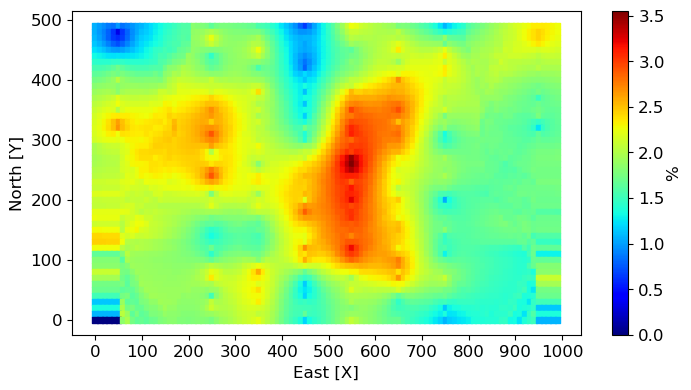

In [33]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df["X"], df["Y"], marker_size, df["V_OK"], cmap = cmap, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
#plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/sample_regular_kriging_100.png", dpi=300)

plt.show()

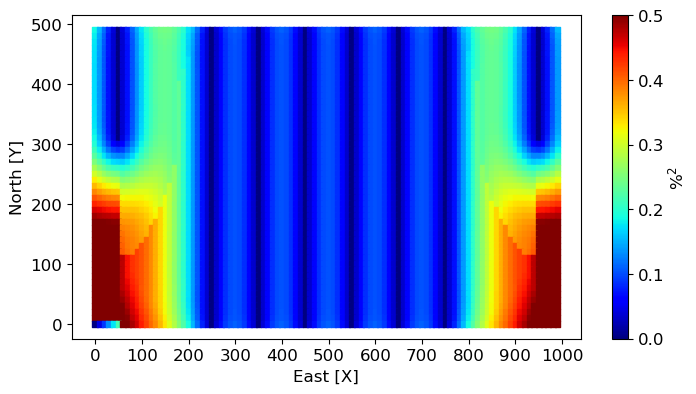

In [73]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df["X"], df["Y"], marker_size, df["Var"], cmap = cmap, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 0.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("%$^2$", labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/var_escenario2_caso1.png", dpi=300)

plt.show()

In [35]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
x = df["V_OK"]
y = df["V"] 

# Suponiendo que x e y son arrays de NumPy o listas
# Si son series de pandas, puedes convertirlas usando: x = x.values, y = y.values

# Calcular el coeficiente de correlación lineal (R)
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y, x)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y, x)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = sqrt(mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y, x)

print(f"Coeficiente de correlación lineal (R): {correlation_coefficient}")
print(f"Coeficiente de determinación (R^2): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")
print(f"Error absoluto medio (MAE): {mae}")

Coeficiente de correlación lineal (R): 0.6414807125432525
Coeficiente de determinación (R^2): 0.39157755581325726
Error cuadrático medio (MSE): 0.18404778936648972
Raíz del error cuadrático medio (RMSE): 0.42900791294157936
Error absoluto medio (MAE): 0.3106666661303056


(-0.3, 3.9)

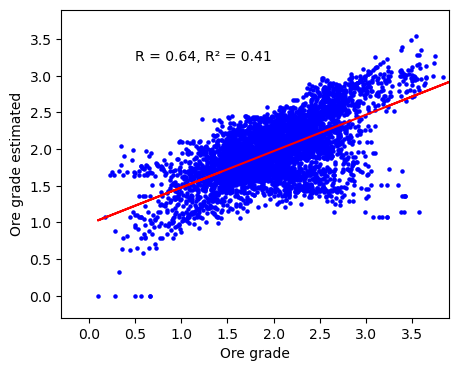

In [36]:
x = df["V"] 
y = df["V_OK"] 
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept
r2 = r2_score(y, regression_line)
r = np.corrcoef(x, y)[0, 1]

fig = plt.figure(figsize=(5,4))
plt.scatter(x, y, color='blue', s=5, label='Data Points')
#plt.title("Validation OK", fontsize=12)
plt.plot(x, regression_line, color='red', label='Regression Line')
plt.text(0.5,3.2, 'R = {:.2f}, R\u00b2 = {:.2f}'.format(r, r2))
plt.xlabel("Ore grade")
plt.ylabel("Ore grade estimated")
plt.xlim((-0.3,3.9))
plt.ylim((-0.3,3.9))
#plt.savefig("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER/data/dh_validation_ok_10percent.png", dpi=300)

# COMPARACIÓN DISTRIBUCIONES MLP VS OK 

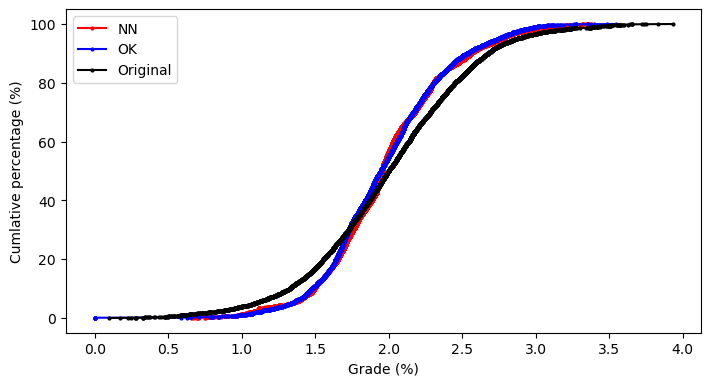

In [75]:
# Seleccionar las columnas relevantes para la comparación
selected_columns = ["V", "VA_RNA", "V_OK"]
df_selected = df[selected_columns]

# Etiquetas personalizadas y colores
custom_labels = {
    "VA_RNA": "NN",
    "V_OK": "OK",
    "V": "Original"
}
custom_colors = {
    "VA_RNA": "red",
    "V_OK": "blue",
    "V": "black"
}

marker_size = 2  # Cambia este valor según lo desees

# Genera el gráfico de distribución acumulada en forma de curva
plt.figure(figsize=(8.2, 4.2))
for column in df_selected.columns[1:]:
    values = np.sort(df_selected[column])
    cumulative_percentiles = np.arange(1, len(values) + 1) / len(values) * 100
    plt.plot(values, cumulative_percentiles, marker='o', markersize=marker_size, label=custom_labels[column], color=custom_colors[column])

# Agregar la variable "V" al gráfico
values_v = np.sort(df_selected["V"])
cumulative_percentiles_v = np.arange(1, len(values_v) + 1) / len(values_v) * 100
plt.plot(values_v, cumulative_percentiles_v, marker='o', markersize=marker_size, label=custom_labels["V"], color=custom_colors["V"])

plt.xlabel("Grade (%)")
plt.ylabel("Cumlative percentage (%)")
plt.legend()
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/distribuciones_Caso_1_escenario2.png", dpi=300)

plt.show()

# Modelo Hibrido MLP-OK

In [38]:
df.head()

,X,Y,V,GEO,VA_RNA,Var,V_OK
0,0.0,490.0,1.425655,0,1.439603,0.187132,1.062005
1,10.0,490.0,1.398962,0,1.422443,0.152383,0.996280
2,20.0,490.0,1.188708,0,1.405215,0.116073,0.929009
3,30.0,490.0,0.992036,0,1.392186,0.078479,0.867346
4,40.0,490.0,0.680945,0,1.381803,0.039985,0.839161


In [39]:
#Estandarización de la varianza:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df["Var_scaled"] = scaler.fit_transform(df[["Var"]])

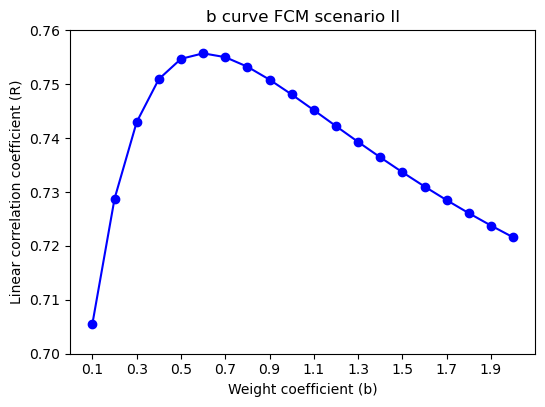

In [85]:
# Definir el rango de valores de b
b_values = np.arange(0.1, 2.1, 0.1)

# Inicializar listas para almacenar los valores de R para cada escenario de b
r_values = []

# Crear una figura para el gráfico
fig = plt.figure(figsize=(6, 4.2))

# Iterar a través de los valores de b y calcular los valores de R correspondientes
for b in b_values:
    df["b_05"] = df["Var_scaled"] ** b
    df["mlp_ok"] = ((df["VA_RNA"]*df["b_05"])+((1-df["b_05"])*df["V_OK"]))
    
    x = df["V"]
    y = df["mlp_ok"]
    r = np.corrcoef(x, y)[0, 1]
    
    r_values.append(r)

# Crear el gráfico de líneas para los valores de R
plt.plot(b_values, r_values, marker='o', linestyle='-', color='blue')
plt.xlabel("Weight coefficient (b)")
plt.ylabel("Linear correlation coefficient (R)")
plt.title("b curve FCM scenario II")
plt.xticks(np.arange(0.1, 2.1, 0.2))  # Ajustar las marcas en el eje X para que se muestren cada unidad
plt.grid(False)
plt.xlim((0,2.1))
plt.ylim((0.7, 0.76))

plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/RFBNN_python/hibrid_figures/b_curve_e2.png", dpi=300)

plt.show()

In [41]:
df["b_05"] = df["Var_scaled"]**0.6 #se crea un nuevo peso (wi) que depende de var**0.5

In [42]:
df["mlp_ok"] = ((df["VA_RNA"]*df["b_05"])+((1-df["b_05"])*df["V_OK"])) #Estimación Hibrida con nuevo peso b=0.5

(-0.3, 3.9)

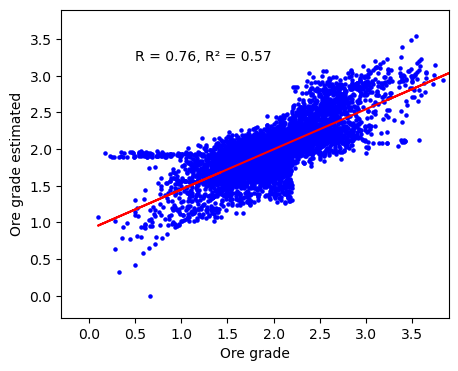

In [43]:
x = df["V"] 
y = df["mlp_ok"] 
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept
r2 = r2_score(y, regression_line)
r = np.corrcoef(x, y)[0, 1]

fig = plt.figure(figsize=(5,4))
plt.scatter(x, y, color='blue', s=5, label='Data Points')
#plt.title("Validation OK", fontsize=12)
plt.plot(x, regression_line, color='red', label='Regression Line')
plt.text(0.5,3.2, 'R = {:.2f}, R\u00b2 = {:.2f}'.format(r, r2))
plt.xlabel("Ore grade")
plt.ylabel("Ore grade estimated")
plt.xlim((-0.3,3.9))
plt.ylim((-0.3,3.9))
#plt.savefig("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER/data/dh_validation_ok_10percent.png", dpi=300)

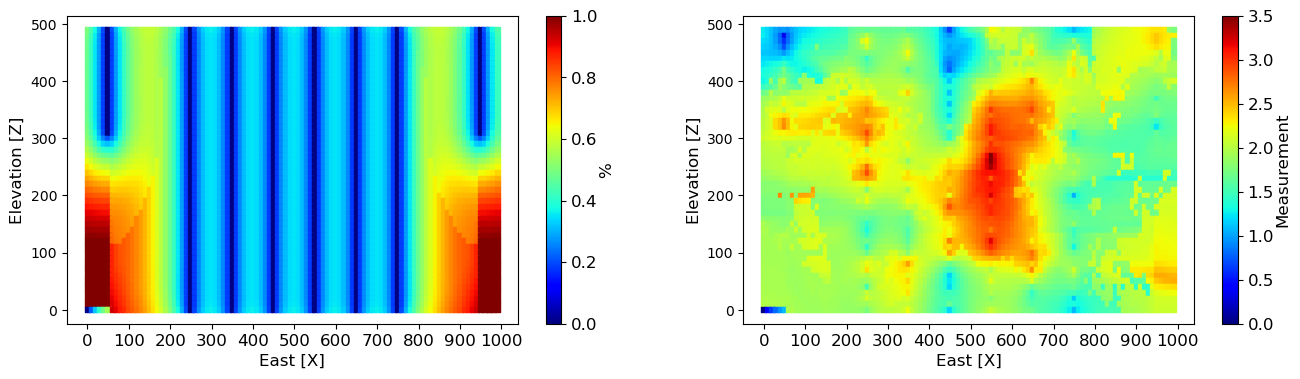

In [44]:
marker_size=15
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["b_05"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 1)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df["X"], df["Y"], marker_size, df["mlp_ok"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Measurement', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/RFBNN_python/hibrid_figures/kriging.png", dpi=300)

plt.show()

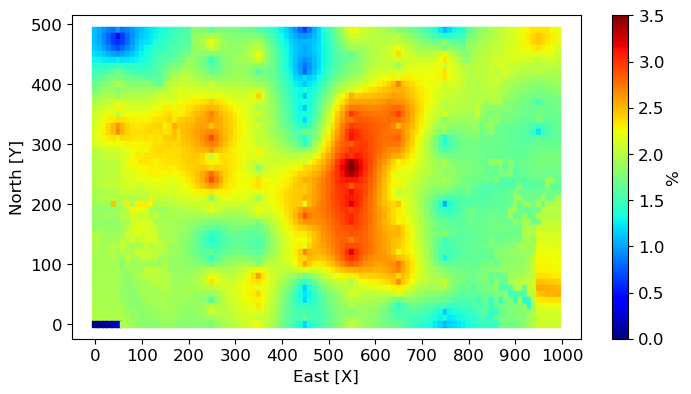

In [76]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df["X"], df["Y"], marker_size, df["mlp_ok"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/combinado_Flexible.png", dpi=300)

plt.show()

In [45]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
x = df["mlp_ok"]
y = df["V"] 

# Suponiendo que x e y son arrays de NumPy o listas
# Si son series de pandas, puedes convertirlas usando: x = x.values, y = y.values

# Calcular el coeficiente de correlación lineal (R)
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y, x)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y, x)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = sqrt(mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y, x)

print(f"Coeficiente de correlación lineal (R): {correlation_coefficient}")
print(f"Coeficiente de determinación (R^2): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")
print(f"Error absoluto medio (MAE): {mae}")

Coeficiente de correlación lineal (R): 0.7557298371147975
Coeficiente de determinación (R^2): 0.5700374107226127
Error cuadrático medio (MSE): 0.1300636832564097
Raíz del error cuadrático medio (RMSE): 0.3606434295206412
Error absoluto medio (MAE): 0.26722177506771


In [ ]:
df.to_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/result_ok_mlp_case1_ESCENARIO_B.csv")

# MODELO RIGIDO:

In [51]:
df.head()

,X,Y,V,GEO,VA_RNA,Var,V_OK,Var_scaled,b_05,mlp_ok
0,0.0,490.0,1.425655,0,1.439603,0.187132,1.062005,0.315466,0.099519,1.099583
1,10.0,490.0,1.398962,0,1.422443,0.152383,0.996280,0.256886,0.065991,1.024402
2,20.0,490.0,1.188708,0,1.405215,0.116073,0.929009,0.195676,0.038289,0.947243
3,30.0,490.0,0.992036,0,1.392186,0.078479,0.867346,0.132300,0.017503,0.876532
4,40.0,490.0,0.680945,0,1.381803,0.039985,0.839161,0.067407,0.004544,0.841626


In [55]:
columnas = ["X","Y", "V", "VA_RNA", "Var", "V_OK"]
df_rigido = df[columnas]
df_rigido.head()

,X,Y,V,VA_RNA,Var,V_OK
0,0.0,490.0,1.425655,1.439603,0.187132,1.062005
1,10.0,490.0,1.398962,1.422443,0.152383,0.996280
2,20.0,490.0,1.188708,1.405215,0.116073,0.929009
3,30.0,490.0,0.992036,1.392186,0.078479,0.867346
4,40.0,490.0,0.680945,1.381803,0.039985,0.839161


In [67]:
# Crear la nueva columna 'rigid' con valores basados en la condición
df_rigido['rigid'] = df_rigido.apply(lambda row: row['VA_RNA'] if row['Var'] > 0.25 else row['V_OK'], axis=1)
df_rigido.head()

C:\TEMP\ipykernel_22568\3447138609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rigido['rigid'] = df_rigido.apply(lambda row: row['VA_RNA'] if row['Var'] > 0.25 else row['V_OK'], axis=1)


,X,Y,V,VA_RNA,Var,V_OK,rigid
0,0.0,490.0,1.425655,1.439603,0.187132,1.062005,1.062005
1,10.0,490.0,1.398962,1.422443,0.152383,0.996280,0.996280
2,20.0,490.0,1.188708,1.405215,0.116073,0.929009,0.929009
3,30.0,490.0,0.992036,1.392186,0.078479,0.867346,0.867346
4,40.0,490.0,0.680945,1.381803,0.039985,0.839161,0.839161


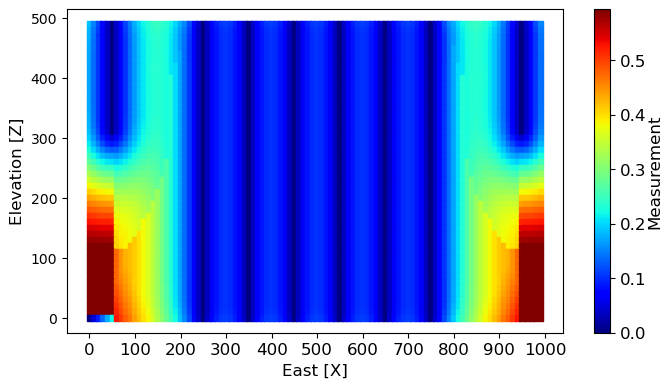

In [71]:
marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["Var"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
#plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Measurement', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/RFBNN_python/hibrid_figures/kriging.png", dpi=300)

plt.show()

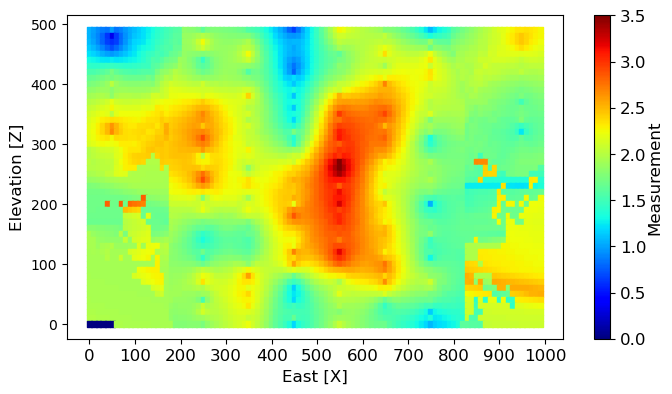

In [77]:
marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["rigid"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Measurement', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/combinado_rigido.png", dpi=300)

plt.show()

In [72]:
x = df_rigido["rigid"]
y = df_rigido["V"]

# Suponiendo que x e y son arrays de NumPy o listas
# Si son series de pandas, puedes convertirlas usando: x = x.values, y = y.values

# Calcular el coeficiente de correlación lineal (R)
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y, x)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y, x)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = sqrt(mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y, x)

print(f"Coeficiente de correlación lineal (R): {correlation_coefficient}")
print(f"Coeficiente de determinación (R^2): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")
print(f"Error absoluto medio (MAE): {mae}")

Coeficiente de correlación lineal (R): 0.7380132930631992
Coeficiente de determinación (R^2): 0.5442795731605949
Error cuadrático medio (MSE): 0.13785542911892007
Raíz del error cuadrático medio (RMSE): 0.3712888755658053
Error absoluto medio (MAE): 0.27437649695623334


In [92]:
df_rigido.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5000.0,495.000000,288.689571,0.000000e+00,247.500000,495.000000,742.500000,990.000000
Y,5000.0,245.000000,144.323130,0.000000e+00,120.000000,245.000000,370.000000,490.000000
V,5000.0,2.000000,0.550055,9.669300e-02,1.642968,2.000339,2.364052,3.931615
VA_RNA,5000.0,1.984730,0.430653,6.517788e-01,1.706716,1.955750,2.245511,3.376422
Var,5000.0,0.151371,0.139740,-3.103517e-15,0.062866,0.098316,0.224373,0.593192
V_OK,5000.0,1.971606,0.425104,0.000000e+00,1.686157,1.946080,2.233815,3.546454
rigid,5000.0,2.004366,0.415803,0.000000e+00,1.723120,1.970136,2.261545,3.546454
FCMe2,5000.0,1.968276,0.423248,4.986978e-29,1.671332,1.935699,2.228405,3.546454


In [91]:
df78 = pd.read_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/result_ok_mlp_case1_ESCENARIO_B.csv")
df78.head()

,Unnamed: 0,X,Y,V,VA_RNA,Var,V_OK,Var_scaled,b_05,mlp_ok
0,0,0.0,490.0,1.425655,1.020032,0.187132,1.062005,0.315466,0.099519,1.057828
1,1,10.0,490.0,1.398962,1.034870,0.152383,0.996280,0.256886,0.065991,0.998826
2,2,20.0,490.0,1.188708,1.055312,0.116073,0.929009,0.195676,0.038289,0.933845
3,3,30.0,490.0,0.992036,1.127225,0.078479,0.867346,0.132300,0.017503,0.871895
4,4,40.0,490.0,0.680945,1.198920,0.039985,0.839161,0.067407,0.004544,0.840795


In [89]:
df_rigido["FCMe2"] = df78["mlp_ok"]

C:\TEMP\ipykernel_22568\19482346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rigido["FCMe2"] = df78["mlp_ok"]


In [93]:
df_rigido["FCMe22"]= df["mlp_ok"]

C:\TEMP\ipykernel_22568\2528182937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rigido["FCMe22"]= df["mlp_ok"]


In [94]:
df_rigido.to_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Hybrid_model_test_2023/df_rigido_e2.csv")